# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План исследования**
1. Загрузим данные
2. Изучим данные. 
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Выберем лучшую модель, проверим её качество на тестовой выборке.

**Описание данных**
Признаки:    
DateCrawled — дата скачивания анкеты из базы    
VehicleType — тип автомобильного кузова    
RegistrationYear — год регистрации автомобиля    
Gearbox — тип коробки передач    
Power — мощность (л. с.)    
Model — модель автомобиля     
Kilometer — пробег (км)     
RegistrationMonth — месяц регистрации автомобиля     
FuelType — тип топлива     
Brand — марка автомобиля     
NotRepaired — была машина в ремонте или нет     
DateCreated — дата создания анкеты     
NumberOfPictures — количество фотографий автомобиля     
PostalCode — почтовый индекс владельца анкеты (пользователя)     
LastSeen — дата последней активности пользователя      
Целевой признак:      
Price — цена (евро)    

## Подготовка данных

In [217]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import warnings

from catboost import CatBoostRegressor
from catboost import Pool, cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor


In [218]:
#откроем файл с данными
df = pd.read_csv('/datasets/autos.csv')
#изучим данные
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [219]:
#изучим данные воспользовавшись унифицированной функцией
def uni_function(function):
    display(function.head())
    display(function.info())
    display(function.isna().mean().sort_values(ascending = False)) #доля пропущенных значений
    display(function.describe())
    display(function.duplicated().sum())

In [220]:
display(uni_function(df))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


4

None

Изучив исходные данные мы обнаружили:
1. Столбцы содержащие информацию о датах имеют неверный формат;
2. В таблице обнаружены дубликаты;
3. Столбцы NotRepaired, VehicleType,FuelType, Gearbox,Model имеют пропуски. Необходимо рассмотреть эти столбцы отдельно и проанализировать, возможно ли заполнить пропуски.
4. Название столбцов считаюся приемлемыми, но для личного удобства, переименуем их.
5. В столбцах Price, Power, RegistrationMonth минимальные значения равны 0. Если для цены такие значения принять возможно, например, в случае, если машину хотят утилизировать, а вот для мощности двигателя и месяца регистрации автомобиля такие значения невозможны. Необходимо узучить эти столбцы более детально. Данные столбца Price мы не будем редактировать еще и потому что это целевой признак, а для целевого признака нам важны все значения.
6. Столбце RegistrationYear также имеет странные значения. минимум составляет 1000, максимум 9999. Также исследуем эти данные на выбросы.

### Переименование столбцов

**Признаки**   
DateCrawled — дата скачивания анкеты из базы    
VehicleType — тип автомобильного кузова     
RegistrationYear — год регистрации автомобиля     
Gearbox — тип коробки передач     
Power — мощность (л. с.)     
Model — модель автомобиля     
Kilometer — пробег (км)     
RegistrationMonth — месяц регистрации автомобиля     
FuelType — тип топлива     
Brand — марка автомобиля     
NotRepaired — была машина в ремонте или нет     
DateCreated — дата создания анкеты      
NumberOfPictures — количество фотографий автомобиля      
PostalCode — почтовый индекс владельца анкеты (пользователя)      
LastSeen — дата последней активности пользователя     

In [221]:
#приведем все названия к нижнему регистру
df.columns = df.columns.str.lower()

In [222]:
#переименуем столбцы
df = df.rename(columns={'datecrawled': 'date_crawled', 
                        'vehicletype': 'vehicle_type', 
                        'registrationyear': 'registration_year', 
                        'registrationmonth': 'registration_month', 
                        'fueltype': 'fuel_type',
                        'notrepaired' : 'not_repaired',
                        'datecreated' : 'date_created',
                        'numberofpictures' : 'number_of_pictures',
                        'postalcode' : 'postal_code',
                        'lastseen' : 'last_seen'})

### Удаление дубликатов и пропусков

In [223]:
#преобразуем тип данных в столбцах имеющих информацию о времени
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%dT%H:%M:%S')

In [224]:
#узнаем, в каком году была выгружена последняя анкета. Это помощет нам ограничить год регистрации автомобиля в дальшейшем.
(df['date_crawled'].max())

Timestamp('2016-04-07 14:36:58')

In [225]:
#удалим неинформативные признаки 
# date_crawled, date_created, last_seen - даты скачивания и создания объявления, дата последней активности пользователя
# number_of_pictures -  количество фотографий автомобиля во всех строчках значение 0
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'postal_code'], axis=1)

In [226]:
#удалим явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [227]:
#еще раз оценим долю пропусков
pd.DataFrame(round((df.isna().mean()*100).sort_values(ascending=False),2)).style.background_gradient('coolwarm')

,0
not_repaired,20.320000
vehicle_type,10.790000
fuel_type,9.520000
model,5.670000
gearbox,5.380000
price,0.000000
registration_year,0.000000
power,0.000000
kilometer,0.000000
registration_month,0.000000


Процентное значение пропусков в столбцах очень высокое, мы не можем удалить такие данные. Изучим их и по возможности устраним.

In [228]:
#создадим функцию для определния уникальных значений
def value_function(column_name):
    display(df[column_name].unique())
    display(df[column_name].value_counts())

In [229]:
#изучим столбец not_repaired
#определим уникальные значения
value_function('not_repaired')

array([nan, 'yes', 'no'], dtype=object)

no     225970
yes     34429
Name: not_repaired, dtype: int64

Исходя из полученных данных мы можешь предположить, что, если графа не заполнена, значит автомобиль не попадал в аварии, а значит можно эти строки заполнить фразой 'no'.

In [230]:
#изучим столбец vehicle_type
#определим уникальные значения
value_function('vehicle_type')

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

sedan          83602
small          73496
wagon          59662
bus            26795
convertible    18752
coupe          15120
suv            10977
other           3173
Name: vehicle_type, dtype: int64

In [231]:
#изучим столбец model
#определим уникальные значения
display(df['model'].unique())
display(df['model'].value_counts())

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

golf                  26444
other                 23231
3er                   18037
polo                  11934
corsa                 11381
                      ...  
kalina                    8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

In [232]:
#изучим столбец fuel_type
#определим уникальные значения
display(df['fuel_type'].unique())
display(df['fuel_type'].value_counts())

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol      200260
gasoline     89464
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: fuel_type, dtype: int64

In [233]:
#изучим столбец fuel_type
#определим уникальные значения
display(df['fuel_type'].unique())
display(df['fuel_type'].value_counts())

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol      200260
gasoline     89464
lpg           4934
cng            529
hybrid         228
other          200
electric        89
Name: fuel_type, dtype: int64

In [234]:
#изучим столбец gearbox
#определим уникальные значения
display(df['gearbox'].unique())
display(df['gearbox'].value_counts())

array(['manual', 'auto', nan], dtype=object)

manual    248135
auto       61113
Name: gearbox, dtype: int64

In [235]:
#выделим категориальные столбцы
category_columns = ['not_repaired', 'vehicle_type', 'model', 'fuel_type', 'gearbox', 'brand']


по имеющимся данным, пропуски заполнить трудно, поэтому, мы принимаем решение заполнить пропущенные значения Nan на значение 'unknown'. Так при необходимости эти значения можно быстро убрать из датасета и в тоже время мы не потяреям большое количество данных.

In [236]:
df[category_columns] = df[category_columns].fillna('unknown')
display(df.head())


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Проверка корреляции

<AxesSubplot:>

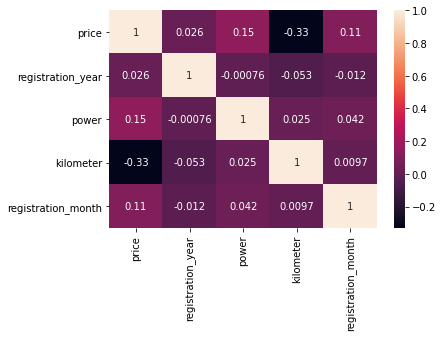

In [237]:
#посчитаем корреляцияю
sns.heatmap(df.corr(), annot = True)

**Вывод**    
Проверка корреляции является методом определения линейной зависимости между параметрами. С его помощью можно определить какие функции больше всего влияют на целевую переменную.    
Исходя из полученных данных, мы видим, что линейная связь практически у всех признаков слабая или отсутствует полностью. Однако стоит обратить внимание, что признак kilometer(пробег, км) оказывает влияние на наш целевой признак price(цена,евро). Коэффициент отрицательный, а значит рост одной величины связан с уменьшением другой. Т.о., чем больше пробег автомобиля, тем ниже будет его рыночная цена.

### Анализ редких и выбивающихся значений

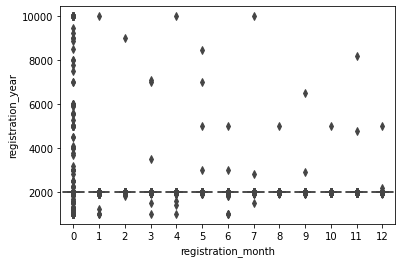

In [238]:
#постороим диаграмму размаха для определения выбросов
sns.boxplot(data=df, y='registration_year', x='registration_month')
plt.show()

#### Исследование месяца регистрации

Из диаграммы мы видим, что большое количество значений сконцентрированно у значения 0, что может говорить о том, что пользователи, размещающие анкеты не знают этой информации, либо не считают важной. Для проверки этого предложения, постороим гистограмму по параметру - месяц регистрации.     

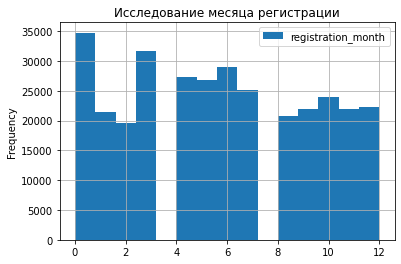

In [239]:
#Построем гистограмму для параметра 'registration_month'.
df.plot(y='registration_month', kind='hist',title='Исследование месяца регистрации', grid=True, bins=15, range=(0, 12))
plt.show()

Значений с нулевым месяцем действительно много, но в целом, мы видим, что значения по месяцам распределены достаточно равномерно. А значит можно сделать вывод о том, что на диаграмме размаха мы видим, что в графе с нулевым значением скорее всего будет также указан неверный год.
Удалим нулевые значения в столбце месяц регистрации.

In [240]:
#удалим нулевые значения
df_filt_month = df.loc[df['registration_month'] != 0] #датафрейм без нулевых значений в стобце registration_month

In [241]:
#процент удаленных строк
procent_month = (df.shape[0] - df_filt_month.shape[0])/df.shape[0] * 100
print('Процент удаленных строк', procent_month)

Процент удаленных строк 10.635016797929172


Процент потери данных при удалении очень большой, судя по графику корреляции, месяц регистрации практически не влияет на ценообразование. Чтобы сохранить данные других столбцов, удалим столбец с месяцем регистрации.

In [242]:
df = df.drop(['registration_month'], axis=1)
display(df.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### Исследование года регистрации

Известно что, только в 1885 году появился повсеместно используемый сегодня газолиновый или бензиновый двигатель внутреннего сгорания. Также значения ниже этого года мы отметаем сразу. В конце 1980-х гг. на территорию Советского Союза начали проникать иномарки, а значит, мы можем рассмотреть данные начиная с этого года по 2016 год( год выгрузки последней анкеты). Сравним значения предложенныенами, со значениями определенными с помощью диаграммы размаха.

In [243]:
#рассчитаем крайние значения 'усов'
Q3 = df['registration_year'].describe()['75%'] #Третий квартиль
Q1 = df['registration_year'].describe()['25%'] #Первый квартиль 
IQR = Q3-Q1 #Межквартильный размах 
right_mustache = 2016 #правый ус. По границе выгрузки последней анкеты
left_mustache = Q1 - 1.5*IQR #правый ус. Левый ус
print(right_mustache)
print(left_mustache)

2016
1985.5


In [244]:
#отфильтруем выбивающиеся значения по диаграмме размаха.
df_filt_year = df.query('1985 <= registration_year <= 2016')
print('Количество строк в отфильтрованной таблице:',df_filt_year.shape[0])
print('Количество строк в исходной таблице:',df.shape[0])

Количество строк в отфильтрованной таблице: 307776
Количество строк в исходной таблице: 326826


In [245]:
#процент удаленных строк
procent_year = (df.shape[0] - df_filt_year.shape[0])/df.shape[0] * 100
print('Процент удаленных строк', procent_year)

Процент удаленных строк 5.828789631179894


In [246]:
df_filt_year.describe()

,price,registration_year,power,kilometer
count,307776.000000,307776.000000,307776.000000,307776.000000
mean,4433.295845,2002.924676,111.773156,128596.576731
std,4532.643343,5.913553,191.958371,37360.587757
min,0.000000,1985.000000,0.000000,5000.000000
25%,1000.000000,1999.000000,70.000000,125000.000000
50%,2750.000000,2003.000000,105.000000,150000.000000
75%,6450.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2016.000000,20000.000000,150000.000000


При фильтрации данных будет утеряно 4.7% данных. Исходя из условий нашей задачи, мы можем удалить эти данные,т.к . они не информативны(дают нам заведомо ложную информацию). Для наглядности построим гистограмму и рассмотрим, как изменится корреляция, без этих данных.

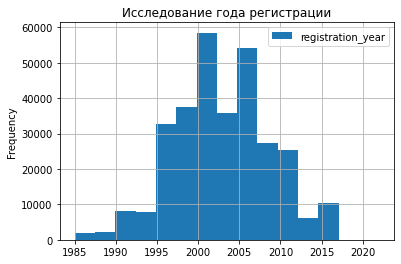

In [247]:
#Построем гистограмму для параметра 'registration_year'.
df_filt_year.plot(y='registration_year', kind='hist',title='Исследование года регистрации', grid=True, bins=15, range=(1985, 2022))
plt.show()

Проверим корреляцию после корректировки данных.

<AxesSubplot:>

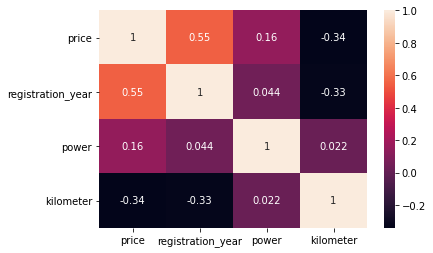

In [248]:
#посчитаем корреляцияю
sns.heatmap(df_filt_year.corr(), annot = True)

Как мы видим, после удаления ненужных данных, корреляция сильно изменилась. Мы видим, что год регистрации авто и пробег влияют на ценообразование. Чем моложе автомобиль, тем выше цена, пробег же наоборот уменьшает стоимость, чем он больше, чем ниже цена. Также стоит отметить, что год регистрации автомобиля и пробег тоже связаны. Чем старше авто, тем меньше пробег.

#### Исследование мощности автомобиля

Максимальная мощность, которую развивает автомобиль, равна 1600 лошадиным силам. Построим диаграмму размаха исходя из этих данных.

(0.0, 1600.0)

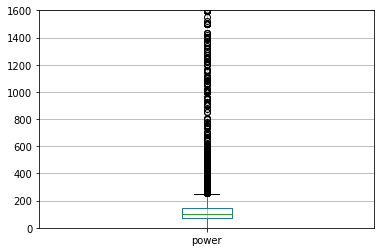

In [249]:
#постороим диаграмму размаха для определения выбросов
df_filt_year.boxplot(column='power')
plt.ylim(0, 1600)

In [250]:
#рассчитаем крайние значения 'усов'
Q3 = df_filt_year['power'].describe()['75%'] #Третий квартиль
Q1 = df_filt_year['power'].describe()['25%'] #Первый квартиль 
IQR = Q3-Q1 #Межквартильный размах 
right_mustache = Q3 + 1.5*IQR #правый ус.  Левый ус находится на границе с 0.
print(right_mustache)

252.5


Как всем известно, мощность автомобиля не может быть равна 0, это аномалия. Т.к. мы рассматриваем автомобили с 1985 года, возьмем минимальную мощность авто, произведенного в то время. Это 54 л.с. Максимальное значение, возьмем по правому "усу" диаграммы размаха.

In [251]:
#отфильтруем выбивающиеся значения по диаграмме размаха.
df_filt_year_pow = df_filt_year.query('54 <= power <= 247.5')
print('Количество строк в отфильтрованной таблице:',df_filt_year_pow.shape[0])
print('Количество строк в исходной таблице:',df_filt_year.shape[0])

Количество строк в отфильтрованной таблице: 259524
Количество строк в исходной таблице: 307776


In [252]:
#процент удаленных строк из отфильтрованного датасета
procent_year_pow = (df_filt_year.shape[0] - df_filt_year_pow.shape[0])/df_filt_year.shape[0] * 100
print('Процент удаленных строк из отфильтрованного датасета', procent_year_pow)
#процент удаленных строк из исходного датасета
procent_full = (df.shape[0] - df_filt_year_pow.shape[0])/df.shape[0] * 100
print('Процент удаленных строк из исходного датасета', procent_full)


Процент удаленных строк из отфильтрованного датасета 15.677635683094199
Процент удаленных строк из исходного датасета 20.592608911163737


Как мы видим, процент удаленных данных очень большой, поэтому трогать этот столбец мы не будем. 

#### Исследование цены автомобиля

При изучении данных в самом начале проект, мы обнаружили, что у целевого признака - цена, минимальное значение равно нулю. Так как этот признак очень важен и нам необходимо цену только с адекватными значениями.

In [253]:
#удалим нулевые значения
df_total = df_filt_year.loc[df_filt_year['price'] != 0]
df_total.describe()

,price,registration_year,power,kilometer
count,299491.000000,299491.000000,299491.000000,299491.00000
mean,4555.936779,2002.995586,112.438681,128642.16287
std,4533.702249,5.872655,189.536171,37104.39360
min,1.000000,1985.000000,0.000000,5000.00000
25%,1199.000000,1999.000000,72.000000,125000.00000
50%,2850.000000,2003.000000,105.000000,150000.00000
75%,6500.000000,2007.000000,143.000000,150000.00000
max,20000.000000,2016.000000,20000.000000,150000.00000


### Преобразование категориальных признаков

In [254]:
df_total.columns
category_columns

['not_repaired', 'vehicle_type', 'model', 'fuel_type', 'gearbox', 'brand']

In [255]:
#преобразуем категориальные признаки в численные с помощью OrdinalEncoder()
ord_enc = OrdinalEncoder()
df_total[category_columns] = ord_enc.fit_transform(df_total[category_columns])

#преобразуем тип данных категориальных признаков
df_total[category_columns] = df_total[category_columns].astype('category')

## Обучение моделей

### Определение выборок 

In [256]:
#извлечем признаки
features = df_total.drop(['price'], axis=1) # извлекаем признаки
target = df_total['price'] # извлекаем целевой признак
print(features.shape)
print(target.shape)

(299491, 9)
(299491,)


In [257]:
#разделите данные на обучающую и тестовую выборки 
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.4,train_size=0.6, random_state = 12345)
print(features_train.shape)
print(features_test.shape)

(179694, 9)
(119797, 9)


In [258]:
# создадим кросс-валидатор для последующего обучения моделей
cv = KFold(n_splits=3, shuffle=True, random_state=12345)
# словарь для результатов обучения
train_score = {}

### Масштабирование признаков

In [259]:
warnings.filterwarnings('ignore')
#применим метод масштабирования — стандартизация данных
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
#display(features_train.head())

Обучим модели( LightGBM, LinearRegression, RandomForestRegressor) и измерим время выполнения кода и rmse для моделей 

### LightGBM

In [260]:
lgbm = LGBMRegressor(random_state=12345)
parameters = {'n_estimators': range (10, 101, 10),
#             'max_depth':[5, 10, 15]}
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15]}
gsearch = GridSearchCV(lgbm, parameters, cv=cv,scoring='neg_mean_squared_error')
gsearch.fit(features_train, target_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
                         'n_estimators': range(10, 101, 10)},
             scoring='neg_mean_squared_error')

In [261]:
best_score = gsearch.best_score_ * (-1)
print("Best score: %0.3f" % best_score)

print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 2489211.742
Best parameters set:
	learning_rate: 0.15
	n_estimators: 100


In [262]:
#определим индекс с лучшими параметрами
best_index_lgbm = gsearch.best_index_

In [263]:
#получим всю информацию по обучению
result_lgbm = pd.DataFrame(gsearch.cv_results_)
result_lgbm.columns
best_result_lgbm = result_lgbm.filter(regex='^(?:mean|param)')
train_time_lgbm = best_result_lgbm['mean_fit_time'].loc[best_result_lgbm.index[best_index_lgbm]]
predict_time_lgbm = best_result_lgbm['mean_score_time'].loc[best_result_lgbm.index[best_index_lgbm]]


In [264]:
booster = lgb.LGBMModel(objective="regression", n_estimators=100, learning_rate=0.15)
booster.fit(features_train, target_train)

predicted_train = booster.predict(features_train)
rmse_train_lgbm = (mean_squared_error(target_train, predicted_train))**0.5  

#predicted_test = booster.predict(features_test)
#rmse_test = (mean_squared_error(target_test, predicted_test))**0.5   


In [265]:
train_score['LightGBM'] = [rmse_train_lgbm, best_score, train_time_lgbm, predict_time_lgbm]
display(train_score['LightGBM'])

[1494.1086522963903,
 2489211.7423238046,
 3.2974509398142495,
 0.6112782955169678]

### LinearRegression

In [291]:
start_time_l_train = time.time()
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
end_time_l_train = time.time() - start_time_l_train


start_time_l_pred = time.time()
predicted_train = lr_model.predict(features_train)
rmse_train = (mean_squared_error(target_train, predicted_train))**0.5  
end_time_l_pred = time.time() - start_time_l_pred 


best_score_lr = cross_val_score(lr_model, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)*(-1)
best_score_lr = sorted(best_score_lr)
display(best_score_lr) #выбирем наименьшее значение

[10396571.940972883, 10416628.313478664, 10491803.858643176]

In [290]:
train_score['LinearRegression'] = [rmse_train, best_score_lr[0], end_time_l_train, end_time_l_pred]
display(train_score['LinearRegression'])

[3229.9508055017186,
 10396571.940972883,
 0.03111577033996582,
 0.010159969329833984]

### DecisionTreeRegressor

In [293]:
dtc = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range (1, 11, 1),
             'min_samples_split': range (2,10,2)}
grid = GridSearchCV(dtc, parameters, cv=cv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 11),
                         'min_samples_split': range(2, 10, 2)},
             scoring='neg_mean_squared_error')

In [306]:
best_score_dtr = grid.best_score_ *(-1)
print("Best score: %0.3f" % best_score_dtr)

print("Best parameters set:")
best_parameters_dtr = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters_dtr[param_name]))


Best score: 3892988.224
Best parameters set:
	max_depth: 10
	min_samples_split: 8


In [307]:
#определим индекс с лучшими параметрами
best_index_dtr = grid.best_index_

In [308]:
result_dtr = pd.DataFrame(grid.cv_results_)
result_dtr.columns
best_result_dtr = result_dtr.filter(regex='^(?:mean|param)')
train_time_dtr = best_result_dtr['mean_fit_time'].loc[best_result_dtr.index[best_index_dtr]]
predict_time_dtr = best_result_dtr['mean_score_time'].loc[best_result_dtr.index[best_index_dtr]]


In [309]:
dtc_model = DecisionTreeRegressor(random_state=12345, max_depth=10, min_samples_split=8) # обучим модель с заданной глубиной дерева
dtc_model.fit(features_train,target_train) # обучим модель вызовом метода fit()
    
predicted_train = dtc_model.predict(features_train) # получим предсказания модели
rmse_train = (mean_squared_error(target_train, predicted_train))**0.5 
    
#predicted_test = dtc_model.predict(features_test)
#rmse_test = (mean_squared_error(target_test, predicted_test))**0.5   

In [310]:
train_score['DecisionTreeRegressor'] = [rmse_train, best_score_dtr, train_time_dtr, predict_time_dtr]
display(train_score['DecisionTreeRegressor'])

[1849.8465129824922,
 3892988.223815596,
 0.23719429969787598,
 0.010281244913736979]

## Анализ моделей

In [311]:
df_score = pd.DataFrame.from_dict(data = train_score, orient='index', columns=['RMSE_train', 'best_score','train_time', 'predict_time'])
display(df_score)

,RMSE_train,best_score,train_time,predict_time
LightGBM,1494.108652,2.489212e+06,3.297451,0.611278
LinearRegression,3229.950806,1.039657e+07,0.031116,0.010160
DecisionTreeRegressor,1849.846513,3.892988e+06,0.237194,0.010281


<AxesSubplot:>

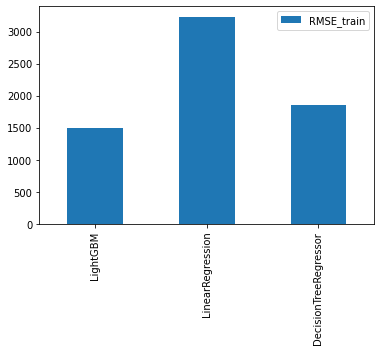

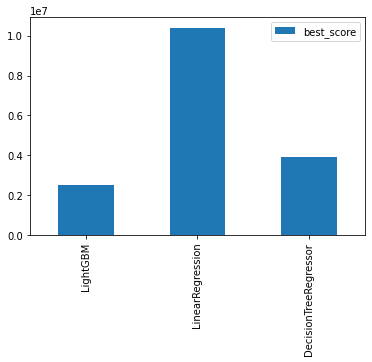

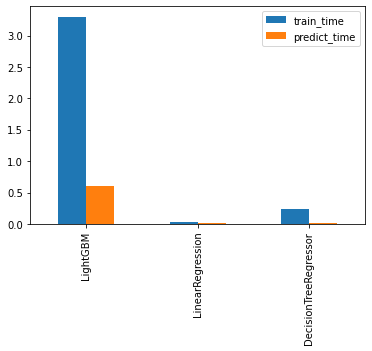

In [312]:
#для лучшей визуализации, построим графики
df_score.plot(kind="bar", y=['RMSE_train'])
df_score.plot(kind="bar", y=['best_score'])
df_score.plot(kind="bar", y=['train_time', 'predict_time'])

**Вывод**

Исходя из наших рассчетов, мы можем сделать вывод о том, что нам могут подойти две модели. LightGBM	имеет лучшие показатели RMSE и оценку модели, однако успутает по времени обучения и предсказания двум другим моделям. Модель DecisionTreeRegressor имеет хорошие показатели по времени обучени и предсказания, однако очень сильно уступает по оценке качества модели. Худшей моделью из рассмотренных является LinearRegression. В нашем проекте модель LightGBM является лучшей. Проверим её на тестовой выборке.

### Проверка лучшей модели на тестовой выборке

In [304]:

gsearch.fit(features_test, target_test)

best_score_test = gsearch.best_score_ * (-1)
print("Best score_test: %0.3f" % best_score_test)

booster_test = lgb.LGBMModel(objective="regression", n_estimators=100, learning_rate=0.15)
booster_test.fit(features_train, target_train)

predicted_test = booster_test.predict(features_test)
rmse_test_lgbm = (mean_squared_error(target_test, predicted_test))**0.5  

print("RMSE наилучшей модели на тестовой выборке:", rmse_test_lgbm)



Best score_test: 2489211.742
RMSE наилучшей модели на тестовой выборке: 1559.6266132078765


In [305]:
#сравним результаты лучшей модели на обучающей и тестовой выборках
comparison_table = [['Best score_train', [best_score ] ],
                   ['Best score_test', [best_score_test] ]]
print(comparison_table)

[['Best score_train', [2489211.7423238046]], ['Best score_test', [2517603.1142293666]]]


**Вывод**    
Значений MSE полученное на тестовой выборке оказалось больше, чем результат полученный нами на обучающей выборке. А значит, качество модели ухудшилось. Однако стоит отметить, что ухудшение модели незначительно.     
Показатель качества модели очень важен. Это самый важный критерий для бизнеса: чем выше качество, тем больше прибыли приносит продукт. А значит, если бы разница между значениями тестовой и обучающей выборок была значительной, нам стоило задуматься о том, правильную ли модель мы выбрали.    
В нашем случае, как и говорилось выше, разница между значениями незначительна, а значит мы можем говорить о том, что выбранная нами модель пригодна для использования.